In [742]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

In [743]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [744]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [745]:
train.shape

(307511, 122)

In [746]:
test.shape

(48744, 121)

In [747]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [748]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [749]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

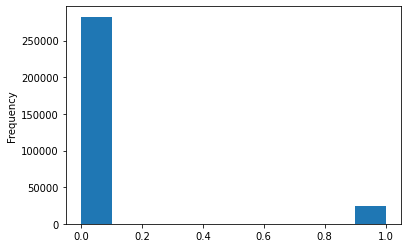

In [750]:
train['TARGET'].astype(int).plot.hist();

In [751]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [752]:
missing_data(train)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
...,...,...
REG_CITY_NOT_LIVE_CITY,0,0.000000
LIVE_REGION_NOT_WORK_REGION,0,0.000000
REG_REGION_NOT_WORK_REGION,0,0.000000
HOUR_APPR_PROCESS_START,0,0.000000


In [753]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [754]:
train.shape

(307511, 246)

In [755]:
test.shape

(48744, 242)

In [756]:
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = train_labels

In [757]:
train.shape

(307511, 243)

In [758]:
test.shape

(48744, 242)

In [759]:
train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.007014,0.001288,0.000276,0.005889,0.028919,0.010559,0.006419,0.124913,0.005122,0.001876,0.001132,0.006179,0.011356,0.000208,0.000159,0.002052,0.025466,0.000654,0.007167,0.003860,0.017554,0.004315,0.180072,0.018494,0.018273,0.240089,0.039283,0.489423,0.004875,0.003941,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3

In [760]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

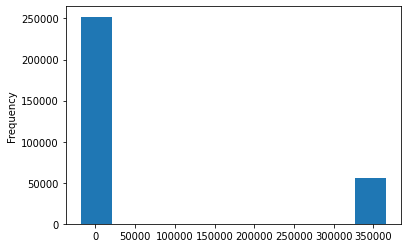

In [761]:
train['DAYS_EMPLOYED'].plot.hist()

In [762]:
train['DAYS_EMPLOYED'].replace(365243, train['DAYS_EMPLOYED'].median(), inplace= True)

In [763]:
train.corr()['TARGET'].sort_values()[::-1]

TARGET                                  1.000000
DAYS_BIRTH                              0.078239
REGION_RATING_CLIENT_W_CITY             0.060893
DAYS_EMPLOYED                           0.058983
REGION_RATING_CLIENT                    0.058899
                                          ...   
CODE_GENDER_F                          -0.054704
NAME_EDUCATION_TYPE_Higher education   -0.056593
EXT_SOURCE_1                           -0.155317
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_3                           -0.178919
Name: TARGET, Length: 243, dtype: float64

In [764]:
train_new_features = train.copy()
test_new_features = test.copy()

In [765]:
train_new_features['ANNUITY_INCOME_PERCENT'] = np.log1p(train_new_features['AMT_ANNUITY'] / train_new_features['AMT_INCOME_TOTAL'])
test_new_features['ANNUITY_INCOME_PERCENT'] = np.log1p(test_new_features['AMT_ANNUITY'] / test_new_features['AMT_INCOME_TOTAL'])

In [766]:
train_new_features['CREDIT_TERM'] = np.log1p(train_new_features['AMT_ANNUITY'] / train_new_features['AMT_CREDIT'])
test_new_features['CREDIT_TERM'] = np.log1p(test_new_features['AMT_ANNUITY'] / test_new_features['AMT_CREDIT'])

In [767]:
tmp = train['TARGET'] 
train = train.drop(['TARGET'], axis=1)
numeric = train.select_dtypes(exclude = ["object"]).columns
categorical = train.select_dtypes(include = ["object"]).columns

In [768]:
missings = [] 

for i in categorical:
  missings.append(train[i].value_counts().idxmax())

for i in range(len(categorical)):
    train[categorical[i]].fillna(missings[i], inplace=True)

for i in numeric:
    train[i].fillna(train[i].median(), inplace=True)
    
for i in range(len(categorical)):
    test[categorical[i]].fillna(missings[i], inplace=True)

for i in numeric:
    test[i].fillna(test[i].median(), inplace=True)

In [769]:
clf = LogisticRegression(solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=1)
clf.fit(X_train, y_train)
train_clf_prediction = clf.predict_proba(X_train)[:,0]  
test_clf_prediction = clf.predict_proba(X_test)[:,0]

In [770]:
preds = np.zeros(len(test))

In [771]:
test['TARGET'] = np.exp(preds) 
test[['SK_ID_CURR', 'TARGET']].to_csv('sub_test.csv', index = False)